<a href="https://colab.research.google.com/github/raynardj/python4ml/blob/master/experiments/deep_dream_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Dream Experiments

Raynard Jon(Xiaochen Zhang)

This code deployment is based on my rough understanding of the following material.

* I first saw this technique on [this distill post](https://distill.pub/2017/feature-visualization/)
* Then some good elaboration on [this google research blog](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
* [This official notebook](https://github.com/google/deepdream/blob/master/dream.ipynb) has some solid code, but it's using Caffe and Octave to do the heavy work

In [0]:
from torchvision.models.vgg import vgg16_bn
import torch
from torch import nn
from torch.nn import functional as F

Load imagenet task pretrained model

In [2]:
model = vgg16_bn(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:04<00:00, 111007925.81it/s]


In [0]:
# Checking GPU CUDA
assert torch.cuda.is_available(), "No GPU cuda, please configure it in setting"

### Upload and image for training

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving sample001.png to sample001.png
User uploaded file "sample001.png" with length 2909707 bytes


In [0]:
from torchvision import transforms as tfm
from PIL import Image

from tqdm import tqdm_notebook as tqdm

In [0]:
tomodel = tfm.Compose([
    tfm.Resize((299,299)),
    tfm.ToTensor(),
#     tfm.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

In [0]:
import numpy as np

In [0]:
def tv(x):
    """
    Total Variance Loss
    """
    rd = np.random.rand()
    if rd >0.25:
        return torch.pow((x[...,1:,1:]-x[..., :-1,:-1]),2).mean()
    elif rd >0.5:
        return torch.pow((x[...,1:,:-1]-x[..., :-1,1:]),2).mean()
    elif rd >0.75:
        return torch.pow((x[...,:-1,:-1]-x[..., 1:,1:]),2).mean()
    else:
        return torch.pow((x[...,:-1,1:]-x[..., 1:,:-1]),2).mean()
        

### Functions to convert tensor back to PIL Image


In [0]:
class UnNormalize(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
class Normalize(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)
        return tensor

In [0]:
unnormalize = UnNormalize()
normalize = Normalize()
toPil = tfm.ToPILImage()

def to_image(x):
    return toPil(torch.clamp_(x,0.,1.))

In [0]:
model = model.cuda()
model = model.eval()

### Helper functions

In [0]:
class jitter:
    def __init__(self, max_scale = 0.075):
        super().__init__()
        self.max_scale = max_scale
    
    def __call__(self):
        self.scale = (np.random.rand()-1) * self.max_scale
        return self.scale

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
def clip(image_tensor):
    """
    from https://github.com/eriklindernoren/PyTorch-Deep-Dream/blob/master/utils.py
    """
    for c in range(3):
        m, s = MEAN[c], STD[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor


### Start image training

In [0]:
original = Image.open("sample001.png")
original = original.convert("RGB")

x = tomodel(original).unsqueeze(0).cuda()
xp = nn.Parameter(x)

opt = torch.optim.Adam([xp,], lr = 1e-3)

### Gradient Ascent

In [304]:
t = tqdm(range(300))
j = jitter(0.005)

for i in t:
    opt.zero_grad()
#     xp.data = xp.data + j()
    xp.data = normalize(xp.data)
    y_ = model.features[:-20](xp)
    
    loss = torch.pow(y_,2).mean()# + tv(xp)*1e1+1e2
    loss.backward()
    g = xp.grad
    
    g = g/ (torch.abs(g).mean())
    xp.data += g*1e-2

#     xp.data = xp.data-j.scale
    xp.data = clip(xp.data)
    xp.data = unnormalize(xp.data)
    t.set_description("loss:\t%s"%(loss.item()))

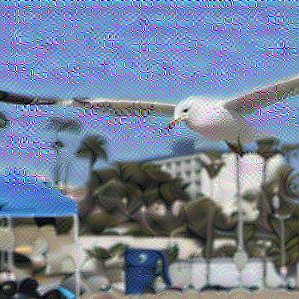

In [305]:
to_image(xp.data[0].cpu())

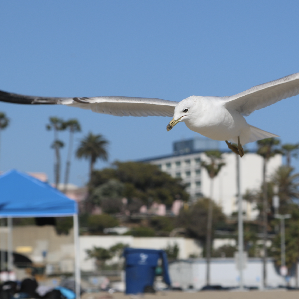

In [19]:
original.resize((299,299))